<a href="https://colab.research.google.com/github/urieliram/analog/blob/main/Analog3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Packages

In [1]:
pip install spectrum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install dtw-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
pip install dtreeviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
pip install statsmodels==0.13.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import time
import timeit
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tools.eval_measures as bias
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LarsCV, Lasso, Ridge, BayesianRidge, LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from math import sqrt
from dtw import *
from scipy import stats

%matplotlib inline
sns.set_theme(style="white")

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



## Load data

In [6]:
#https://drive.google.com/drive/folders/1Gj3XK9kM-lE18uBMe3qrZOGEm8yAI8i9
#https://www.codegrepper.com/code-examples/python/how+to+read+csv+file+from+google+drive+on+google+colab+
path = 'https://drive.google.com/uc?export=download&id=' 
URL  = 'https://drive.google.com/file/d/1057_dPk6rIZgXVku8kmZjq3m8WQNkJZb/view?usp=sharing'
df = pd.read_csv(path+URL.split('/')[-2],usecols=[0,1,2,3,4,5,6,7],names=['Date','SERIE1','SERIE2','SERIE3','SERIE4','SERIE5','SERIE6','SERIE7'],
                 dtype={'Date':str,'SERIE1':float,'SERIE2':float,'SERIE3':float,'SERIE4':float,'SERIE5':float,'SERIE6':float,'SERIE7':float}) #names=['CLVUNI','TYPE','NODE'], usecols=[1,2,3,4,5,6,]
df.dropna(inplace=True)

### ETL 5 minutes

In [7]:
df['Date'] = pd.to_datetime(df['Date'],format= '%d-%m-%Y %H:%M' ) #.dt.date https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.date.html
df = df.set_index('Date')
df_5 = df.resample('5T').mean()
df_5.head()

,SERIE1,SERIE2,SERIE3,SERIE4,SERIE5,SERIE6,SERIE7
Date,,,,,,,
2010-01-01 00:00:00,5547.831152,4353.258496,4927.916309,1355.909058,1697.601026,3396.820703,920.982605
2010-01-01 00:05:00,5535.618164,4348.893457,4916.344433,1353.716626,1699.889233,3397.829590,918.181799
2010-01-01 00:10:00,5529.010351,4331.776856,4897.709473,1346.924121,1697.138647,3424.317334,916.371033
2010-01-01 00:15:00,5514.982032,4330.051758,4879.650098,1346.241382,1705.324194,3421.112500,916.161291
2010-01-01 00:20:00,5472.567285,4314.503906,4863.172266,1334.846802,1674.401562,3409.312451,914.513721


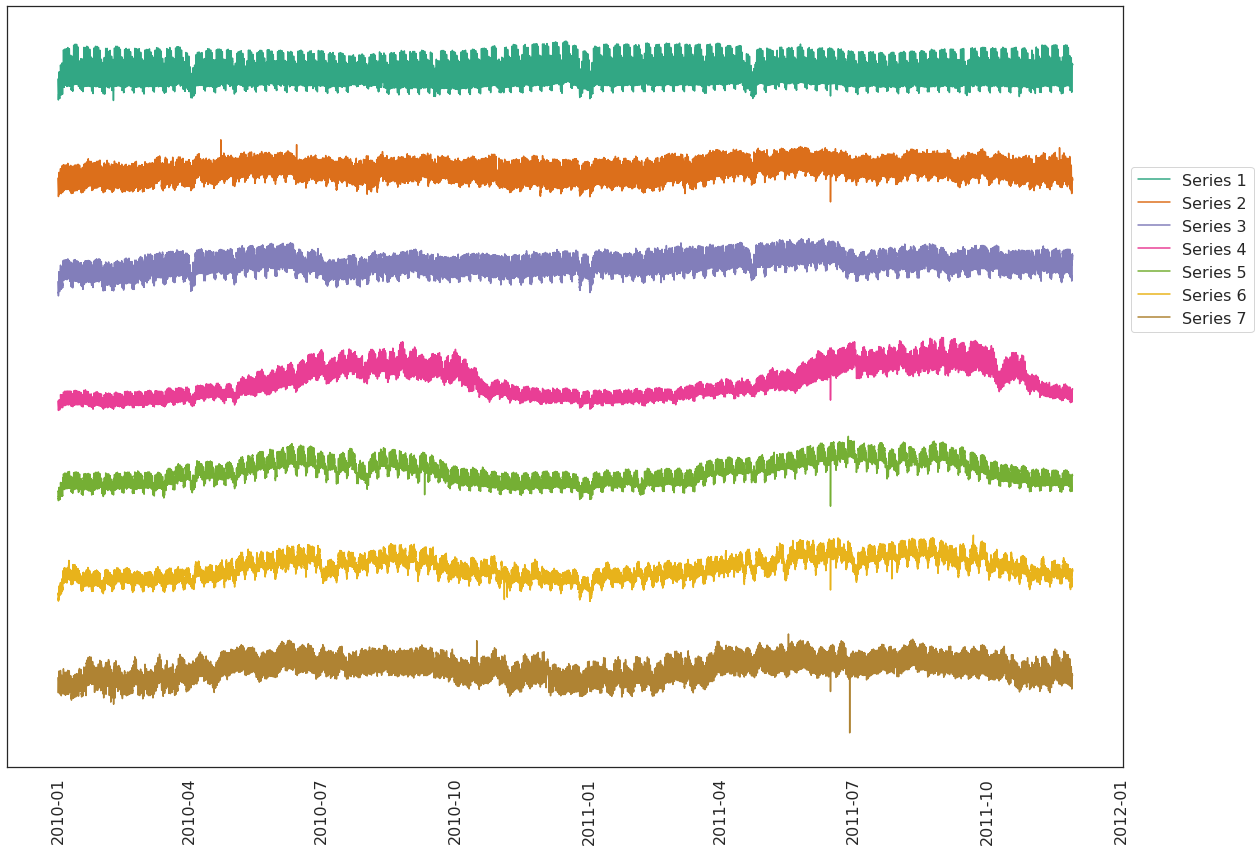

In [8]:
if  True:
    i = 0
    j = 0
    cmap = plt.cm.Dark2 #tab20 https://matplotlib.org/stable/gallery/color/colormap_reference.html
    fig, ax = plt.subplots(figsize=(20,14))
    for ts in df_5:
      max_t = df_5[ts].max()
      plt.plot(df_5[ts].index, df_5[ts] / max_t + j, c = cmap(i), label='Series '+str(i+1),alpha=.9)
      i += 1
      j -= 1
    plt.yticks([])
    plt.xticks(rotation=90, fontsize=16)
    plt.legend(bbox_to_anchor=(1, 0.8), prop={'size': 16})
    plt.savefig('series.pdf')
    plt.show()

## Functions

In [9]:
def trunc(values, decs=0):
    return np.trunc(values*10**decs)/(10**decs)

In [10]:
def diff(list1,list2):
    difference = []
    zip_object = zip(list1, list2)
    for list1_i, list2_i in zip_object:
        difference.append(list1_i-list2_i)
    return difference

In [11]:
CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; NARA='#ff8000'; AZUL='#168fff'; OTROAZUL = "b-"; ROJO= "r-"; MAGE="FF00FF";
def print_serie2(serie_,prototipo_,title_,ytitle_,xtitle_,sizex_=8,sizey_=5,namefile_='fig_t16_serie.png'):
    fig, ax1 = plt.subplots(figsize=(sizex_,sizey_))
    plt.title(title_,fontsize='x-large',color=NARA)
    ax1.set_xlabel(xtitle_, color=NARA, fontsize='large')
    ax1.set_ylabel(ytitle_, color=NARA, fontsize='large')
    plt.tick_params(colors = NARA, which='both')
    ax1.spines['bottom'].set_color(NARA)
    ax1.spines['top'   ].set_color(NARA) 
    ax1.spines['right' ].set_color(NARA)
    ax1.spines['left'  ].set_color(NARA)
    if len(prototipo_) != 0: 
        plt.plot(prototipo_,alpha=0.6, linestyle='dashed', color='red', linewidth=3)
    for p in serie_:
        plt.plot(p,alpha=0.3, linewidth=2)    
    plt.savefig(namefile_, transparent=True)         
    plt.show()

In [12]:
def OLSstep(X, Y, X_2, pi_step_=0.001,verbose_=False):
    model   = sm.OLS(Y, X)
    results = model.fit()
    prediction_Y2 = results.predict(X_2)

    ## We sort the 'pi' values and the largest one is selected.
    i = 0
    pvalues = []
    for pi in results.pvalues:
        pvalues.append((i,pi))
        i = i + 1
    pvalues.sort(key=lambda tup: tup[1], reverse=True) ## We order by 'pi'
    (i, pi) = pvalues[0]  

    while pi > pi:
        X   = sm.add_constant(X)
        X_2 = sm.add_constant(X_2)   
        if verbose_==True:
            print('Retiramos regresor ---> X' + str(i))
        X   = np.delete(arr=X,   obj=i+0, axis=1)
        X_2 = np.delete(arr=X_2, obj=i+0, axis=1)   
        model   = sm.OLS(Y, X)
        results = model.fit()

        ## We sort the 'pi' values and select the largest
        i = 0
        pvalues = []
        for pi in results.pvalues:
            pvalues.append((i,pi))
            i = i + 1
        pvalues.sort(key=lambda tup: tup[1], reverse=True) ## We order by 'pi'
        (i, pi) = pvalues[0]
        #prediction   = results.predict(X)  
        prediction_Y2 = results.predict(X_2)
    if len(prediction_Y2) == 0:      
        if verbose_==True:
            print('>>> Warning, no variable was significant in the regression.')
        model   = sm.OLS(Y, X)
        results = model.fit()
        prediction_Y2 = results.predict(X_2)
        
    if verbose_==True:
        print(results.summary())
    return prediction_Y2   

In [13]:
def RF(X, Y, X_2,labels_,typedist_,verbose_=False):
    model         = RandomForestRegressor(random_state=42)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2   
def Boosting(X, Y, X_2,typedist_,verbose_=False):
    model         = GradientBoostingRegressor(random_state=42,)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2
def Bagging(X, Y, X_2,typedist_,verbose_=False):
    model         = BaggingRegressor(random_state=42,)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2   
def AdaBoost(X, Y, X_2,typedist_,verbose_=False):
    model         = AdaBoostRegressor(random_state=42,)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2 
def LinearReg(X, Y, X_2,typedist_,verbose_=False):
    model         = LinearRegression()
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2
def BayesRidge(X, Y, X_2,typedist_,verbose_=False):
    model         = BayesianRidge(compute_score=True)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2) 
    return prediction_Y2   
def LassoReg(X, Y, X_2,typedist_,verbose_=True):
    model         = Lasso(alpha=0.1)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2  
def RidgeReg(X, Y, X_2,typedist_,verbose_=False):
    model         = Ridge(alpha=0.1)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2    
def PLS(X, Y, X_2,n_components,typedist_,verbose_=False):
    model         = PLSRegression(n_components=n_components)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2
def PCR(X, Y, X_2,n_components,typedist_,verbose_=False):
## https://scikit-learn.org/stable/auto_examples/cross_decomposition/plot_pcr_vs_pls.html
    model         = make_pipeline(PCA(n_components=n_components), LinearRegression())
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2    
def VotingEnsemble(X, Y, X_2,verbose_=False):  
    ## https://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_regressor.html#sphx-glr-auto-examples-ensemble-plot-voting-regressor-py
    gb  = GradientBoostingRegressor(random_state=42)
    rf  = RandomForestRegressor(random_state=42)
    br  = BaggingRegressor(random_state=42)
    ab  = AdaBoostRegressor(random_state=42)
    gb.fit(X, Y)
    rf.fit(X, Y)
    br.fit(X, Y)
    ab.fit(X, Y)
    voting = VotingRegressor([("gb",gb), ("rf",rf), ("br",br), ("ab",ab)]) #
    voting.fit(X, Y)
    prediction_Y2 = voting.predict(X_2)
    return prediction_Y2   
def VotingLinear(X, Y, X_2,verbose_=False):  
    ## https://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_regressor.html#sphx-glr-auto-examples-ensemble-plot-voting-regressor-py
    pl = PLSRegression(n_components=1)
    lr = LinearRegression()
    ri = Ridge(alpha=0.1)
    la = Lasso(alpha=0.1)    
    pc = make_pipeline(PCA(n_components=1), LinearRegression())
    pl.fit(X, Y)
    lr.fit(X, Y)
    ri.fit(X, Y)
    la.fit(X, Y)
    pc.fit(X, Y)
    voting = VotingRegressor([("lr",lr),("ri",ri),("la",la),("pc",pc)]) #,("pl",pl)
    voting.fit(X, Y)
    prediction_Y2 = voting.predict(X_2)    
    return prediction_Y2   

In [14]:
def euclidean(neig1, neig2):
	  distance = 0.0
	  for i in range(len(neig1)):
		    distance += (neig1[i] - neig2[i])**2
	  return sqrt(distance)

In [15]:
def analogo_knn(serie,vsele,k=10,tol=0.8,n_components=3,typedist='pearson',typereg='OLSstep',verbose=False):
    ## vesele   : Size of the selection window / Tamanio de la ventana de selección
    ## k        : Number of neighbours to search for k / Número de vecinos a buscar k
    ## tol      : Window size tolerance for neighbour selection / Tolerancia de tamaño de ventanas para seleccion de vecinos
    ## typedist : distance measure, 'euclidian' or 'pearson' or 'dtw' / medida de distancia, 'euclidian' o 'pearson' o 'dtw' 
    t_o = time.time()
    n = len(serie) 

    ## STEP 1: Selection of the windows with the highest correlation.

    ## Calculate the distance between all neighbors.
    distances = []
    Y = serie[n-vsele:n]           ## latest data
    for i in range(n-2*vsele):                              
        if  typedist == 'dtw':     ## dynamic time warping
            dist = dtw(Y, serie[i:i+vsele]).distance  
        elif typedist == 'euclidian':
            dist = euclidean(Y,serie[i:i+vsele])
        else:
            dist = np.corrcoef(Y,serie[i:i+vsele])[1,0]
        if dist > 0:
            distances.append((i, dist))
        
    ## We calculate the neighbourhood by distance from smallest to largest and the positions are saved.
    if typedist == 'pearson':
        ## In the Pearson backwards case, we are interested in the indices with the highest correlation in Pearson backwards ordering.
        distances.sort(key=lambda tup: tup[1], reverse=True)
    else:
        distances.sort(key=lambda tup: tup[1], reverse=False)

    neighbors  = []
    neighbors2 = []
    positions  = []

    ## We calculate the k nearest neighbors and save the positions.
    i = 0
    for pos, dis in distances:
        if i==0:      
            positions.append(pos)   
            neighbors.append(serie[pos:pos+vsele])
            neighbors2.append(serie[pos+vsele:pos+2*vsele])  
        else:
            bandera = True
            for p in positions:
                 ## if we already had a position in the list that passed the tolerance, we no longer save it
                if (abs(pos - p) < tol*vsele):
                    bandera = False
                    i = i - 1
                    break
            if bandera == True:
                ## save new neighbor
                positions.append(pos)   
                neighbors.append(serie[pos:pos+vsele])
                neighbors2.append(serie[pos+vsele:pos+2*vsele])  
                bandera = False
        i = i + 1
        if i == k:
            break
    if verbose==True:
        print('positions KNN:', positions) ## position of k nearest neighbors

    neighbors  = np.array(neighbors)  
    neighbors2 = np.array(neighbors2)    
    vacia = []
    if verbose==True:
        print_serie2(neighbors,Y,'Selección con KNN:'+typedist,'demanda','time',8,5,'fig_t16_X_'+typedist+'_'+typereg)

    t_sel = time.time() - t_o

    ## STEP 2: Regression between nearest neighbors 'X' and last window 'Y'

    ## Define our regressors
    X   = (neighbors.T ).tolist()
    X_2 = (neighbors2.T).tolist()
    Y   = (Y).tolist()
    prediction_Y2 = []

    ## -- Random forest regression --
    if typereg == 'RF':
        prediction_Y2 = RF(X,Y,X_2,labels_=positions,typedist_=typedist,verbose_=verbose)

    ## -- OLS with Stepwise --
    if typereg == 'OLSstep':
        prediction_Y2 = OLSstep(X,Y,X_2, pi_step_=0.001,verbose_=verbose)

    ## -- Gradiant boosting regression --
    if typereg == 'Boosting':
        prediction_Y2 = Boosting(X, Y, X_2,typedist_=typedist,verbose_=verbose)   

    ## -- Bagging regression --
    if typereg == 'Bagging':
        prediction_Y2 = Bagging(X, Y, X_2,typedist_=typedist,verbose_=verbose)   

    ## -- Linear regression --
    if typereg == 'LinearReg':
        prediction_Y2 = LinearReg(X, Y, X_2,typedist_=typedist,verbose_=verbose)   

    ## -- Ada boosting --
    if typereg == 'AdaBoost':
        prediction_Y2 = AdaBoost(X, Y, X_2,typedist_=typedist,verbose_=verbose)  

    ## -- Bayesian Ridge --
    if typereg == 'BayesRidge':
        prediction_Y2 = BayesRidge(X, Y, X_2,typedist_=typedist,verbose_=verbose)  

    ## -- Lasso regression --
    if typereg == 'LassoReg':
        prediction_Y2 = LassoReg(X, Y, X_2,typedist_=typedist,verbose_=verbose)   

    ## -- Ridge regression --
    if typereg == 'RidgeReg':
        prediction_Y2 = RidgeReg(X, Y, X_2,typedist_=typedist,verbose_=verbose)

    ## -- PLS Regression --
    if typereg == 'PLS':
        prediction_Y2 = PLS(X, Y, X_2,n_components=n_components,typedist_=typedist,verbose_=verbose)

    ## -- PCA Regression --
    if typereg == 'PCR':
        prediction_Y2 = PCR(X, Y, X_2,n_components=n_components,typedist_=typedist,verbose_=verbose)

    ## -- Voting regression with ensemble models -- 
    if typereg == 'VotingEnsemble':
        prediction_Y2 = VotingEnsemble(X,Y,X_2,verbose_=verbose)

    ## -- Voting regression with linear model -- 
    if typereg == 'VotingLinear':
        prediction_Y2 = VotingLinear(X,Y,X_2,verbose_=verbose)
        
    if verbose==True:
        print_serie2(neighbors2,prediction_Y2, 'Forecast - ' + typedist+' - ' + typereg ,'Demand','Time',8,5,'fig_t16_Y2_'+typedist+'_'+typereg)

    t_reg = time.time() - t_sel - t_o

    fail_=False
    if len(prediction_Y2) == 0:
        prediction_Y2=[serie[-1]] * vsele
        fail_=True
        print(">>> analogo_knn: forecast not calculated.")

    ## Draw an example of an analogous space with X, X' and Y, Y'
    if verbose==True:
        fig, ax = plt.subplots(figsize=(8,5))
        ax.legend(['First line', 'Second line'])
        serie1=serie[positions[0]:positions[0]+2*vsele]
        serie2=serie[positions[1]:positions[1]+2*vsele]
        serie3=serie[positions[2]:positions[2]+2*vsele]
        serie4=serie[positions[3]:positions[3]+2*vsele]
        serie5=serie[positions[4]:positions[4]+2*vsele]
        ax.plot(serie1, label='X$_1$')
        ax.plot(serie2, label='X$_2$')
        ax.plot(serie3, label='X$_3$')
        ax.plot(serie4, label='X$_4$')
        ax.plot(serie5, label='X$_5$')
        ax.plot(Y,label='Y', linewidth=3, color='r')   
        c = np.concatenate((Y,prediction_Y2), axis=0)   
        ax.plot(c, label='$Y\'$', linewidth=3, color='r',linestyle='--')      
        plt.legend()
        plt.axvline(x = vsele,linestyle='-.') # '-', '--', '-.', ':',
        ax.set(xlabel='time (5 min)', ylabel='demand (MW)') #title='High correlation windows'
        ax.grid()

        fig.savefig('test'+str(random.randint(1,30000))+'.pdf')
        plt.show()

    if verbose==True:
        print('fail_',fail_) 
        print('t_sel',t_sel) 
        print('t_reg',t_reg) 
        print('prediction_Y2',prediction_Y2) 

    return prediction_Y2, t_sel, t_reg, fail_

In [16]:
## Persistence forecasting
def persistence(serie,n=1):
    out=[]
    for i in range(n):        
        out.append(serie[-1])
    return(out)

In [17]:
## Function that given a datetime, returns its position in the series.
def get_index_day(df,day,month,year):
    df_i = df.reset_index()  ## Integer indices are added.
    idxo=df_i[(df_i.Date.dt.day==day)&(df_i.Date.dt.month==month)&(df_i.Date.dt.year==year)].iloc[ 0]
    idxf=df_i[(df_i.Date.dt.day==day)&(df_i.Date.dt.month==month)&(df_i.Date.dt.year==year)].iloc[-1]
    return(idxo.name,idxf.name)

# Prepare cross-validation for testing

We will use the methodology proposed by Rob J Hyndman [cross-validation in time series](https://robjhyndman.com/hyndsight/tscv/#:~:text=Time%20series%20cross%2Dvalidation,used%20in%20constructing%20the%20forecast.
)


In [18]:
## https://robjhyndman.com/hyndsight/tscv/#:~:text=Time%20series%20cross%2Dvalidation,used%20in%20constructing%20the%20forecast.
## ... year 2010                                                                                                    year 2011
## ... january···february···march···april···may···june···july···august···september···october···november···december···january···february···march···april···may···june···july···august···september···october···november
##    |                                   |      |
##    |<------------- train ------------->|<test>|
##    |<-january·february···march···april->|<may>|
##            |<-february···march···april···may->|<june>|
##                      |<- march···april···may···june ->|<-july->|
##                              |<- april···may···june···july->|<-august->|
##                                     |<-- may···june···july···august->|<-september->|
##                                             |<-june···july···august···september->|<-october->|
##                                                    |<-july···august···september···october->|<-november->|
##                                                           |<-august···september···october···november->|<-december->| ...

df_5_month = df_5.copy()
df_5_month.reset_index(inplace=True)
# https://stackoverflow.com/a/25149272
df_5_month['month'] = df_5_month['Date'].dt.month
df_5_month['year'] = df_5_month['Date'].dt.year
df_5_month = df_5_month.drop_duplicates(['month', 'year'])
df_5_month.index

Int64Index([     0,   8928,  16992,  25920,  34560,  43488,  52128,  61056,
             69984,  78624,  87552,  96192, 105120, 114048, 122112, 131040,
            139680, 148608, 157248, 166176, 175104, 183744, 192672],
           dtype='int64')

In [19]:
## Get the positions (to,tt,tf) from cross-validation
month_i = df_5_month.index
r = range(len(month_i) - 5)
tuplas = []
for i in r:
  tuplas.append((
    # 1 ene       30 abril            31 may
    month_i[i], month_i[i + 4] - 1, month_i[i + 5] - 1
  ))
tuplas.append((157248, 192671, 200638))
tuplas

[(0, 34559, 43487),
 (8928, 43487, 52127),
 (16992, 52127, 61055),
 (25920, 61055, 69983),
 (34560, 69983, 78623),
 (43488, 78623, 87551),
 (52128, 87551, 96191),
 (61056, 96191, 105119),
 (69984, 105119, 114047),
 (78624, 114047, 122111),
 (87552, 122111, 131039),
 (96192, 131039, 139679),
 (105120, 139679, 148607),
 (114048, 148607, 157247),
 (122112, 157247, 166175),
 (131040, 166175, 175103),
 (139680, 175103, 183743),
 (148608, 183743, 192671),
 (157248, 192671, 200638)]

## Public holidays

In [20]:
serie='SERIE1'
print(get_index_day(df_5[serie],10,5,2010))   ## mothers day 2010
print(get_index_day(df_5[serie],10,5,2011))   ## mothers day 2011
print(get_index_day(df_5[serie],24,12,2010))  ## christmas 2010
print(get_index_day(df_5[serie],31,12,2010))  ## new year 2011
print(get_index_day(df_5[serie],1,1,2011))    ## new year 2011

(37152, 37439)
(142272, 142559)
(102816, 103103)
(104832, 105119)
(105120, 105407)


# We select a serie and set its parameters

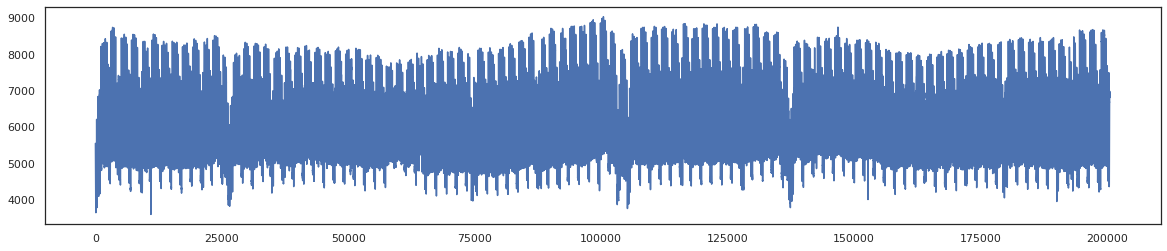

In [21]:
serie1 = df_5.SERIE1.tolist()
plt.figure(figsize=(20, 4))
plt.plot(serie1)
npserie1 = numpy.array(serie1)

In [22]:
## ene2010... time serie·time-serie·time-serie·time-serie·time-serie·time-serie·time-serie·time-serie·time-serie·time-serie·nov2011
##                |                                               |       |           |
##                |                                               |<-n_p->|           |
##                |<------------------ train -------------------->|<-------test------>|
##                to                                              tt   ...j=0...      tf 

n_p       = 30         ## Number of periods per step (Two and half hour)
vsele     = 288        ## Number of periods in a window (a day)
k         = 5          ## Number of nearest neighbors
d         = 'pearson'  ## Distance betweeen neighbors
m         = 'PCR'      ## Regression model
namefile  = 'forecast'
monthyear = 'jun2010'

In [42]:
# >>> provisional para pruebas preliminares (-comentar-)
positions_test= [(8929, 43487, 43987)] ## Predecir junio
positions_test= [(9218, 43770, 43780)] ## falla

# Multi-period **analogue** forecast metafunction **II**:

In [43]:
## Persistence (t=t+1)
forecastp_ = []
timep_      = []
for to,tt,tf in positions_test:
    j=0
    for i in range(tt,tf,1):
        t_o = time.time()
        forecastp_=forecastp_+persistence(serie1[to+j:tt+j],1)
        timep_.append(time.time() - t_o)
        j=j+1

In [44]:
## Prepare the test series
test_ = []
for to,tt,tf in positions_test:
      test_ = test_ + serie1[tt:tf]
print(len(test_))

10


positions KNN: [26776, 30231, 30520, 32248, 24760]


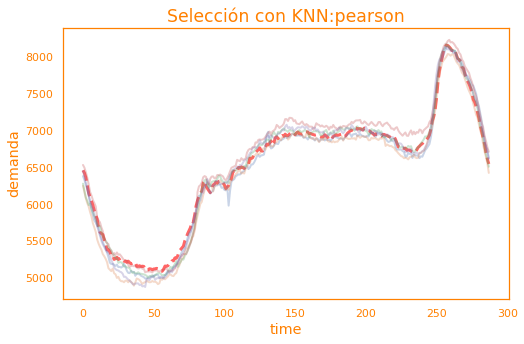

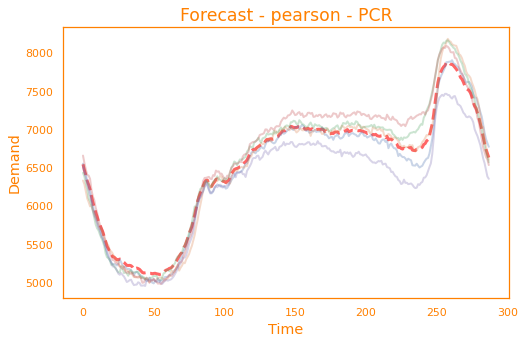

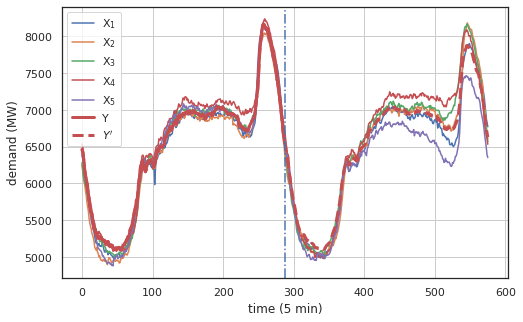

fail_ False
t_sel 6.987833261489868
t_reg 0.7824158668518066
prediction_Y2 [6541.80860401 6465.08670808 6401.77144413 6325.60840311 6273.67106648
 6213.92250815 6122.57809773 6042.72253396 5978.97505743 5909.98508451
 5856.46238326 5794.52870576 5749.25491768 5701.55434072 5657.99502027
 5599.1861101  5536.0813155  5471.41362838 5436.29504646 5396.55931455
 5362.88987282 5334.24737107 5329.30355616 5312.43743491 5293.69171113
 5295.46579526 5303.44052474 5299.74606523 5273.4285034  5260.06425608
 5240.8090533  5221.03554412 5219.55646136 5221.52461044 5216.60567354
 5199.17248708 5169.27919936 5180.77797635 5186.16207529 5179.30446476
 5169.01642879 5147.57920005 5128.12406398 5121.31118545 5124.35485285
 5127.03384676 5117.06579808 5117.82221839 5117.44050788 5109.49537194
 5115.79477405 5117.98800737 5111.78082885 5108.35869802 5102.12758876
 5105.6606373  5110.64208335 5130.61646192 5149.53204064 5160.78175254
 5167.30237219 5180.95686325 5186.59199578 5200.04457637 5225.6880392
 52

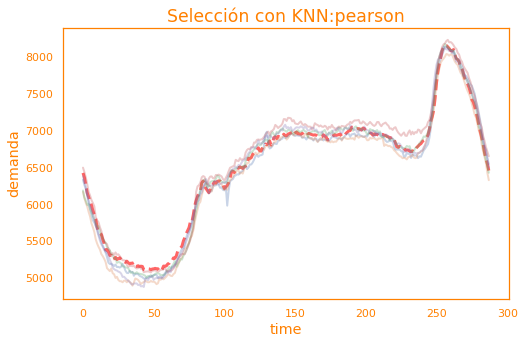

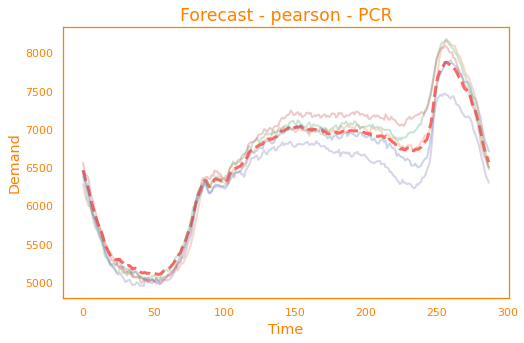

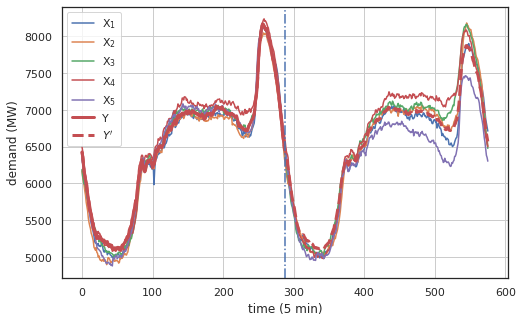

fail_ False
t_sel 7.306670904159546
t_reg 0.4198470115661621
prediction_Y2 [6463.63536809 6400.08443508 6323.89904089 6271.70012509 6212.16586125
 6121.6405699  6041.78554511 5978.15790541 5909.42591453 5855.92701447
 5794.2089477  5748.94093206 5701.4726893  5657.98791749 5599.2375372
 5536.39901577 5472.06152822 5437.15188407 5397.30428673 5363.52451412
 5334.76757912 5329.50869187 5312.54968925 5293.52781864 5294.82486976
 5301.89849877 5298.81584624 5272.73749414 5259.29426962 5239.74997689
 5220.03499283 5218.51610938 5220.68547889 5215.94226233 5198.2587816
 5168.53186114 5179.77759249 5184.9866131  5178.56140514 5168.4344774
 5146.82815641 5127.68569164 5121.02178992 5123.94284721 5127.36825329
 5117.35565281 5118.11788225 5117.86150267 5109.96127784 5116.52811112
 5118.18168182 5112.2329118  5109.01854537 5102.78175738 5105.87363684
 5110.77774216 5130.61222997 5149.34244556 5160.6159661  5167.07521744
 5180.65413231 5186.48637524 5200.1191749  5225.42245451 5245.76623903
 5275

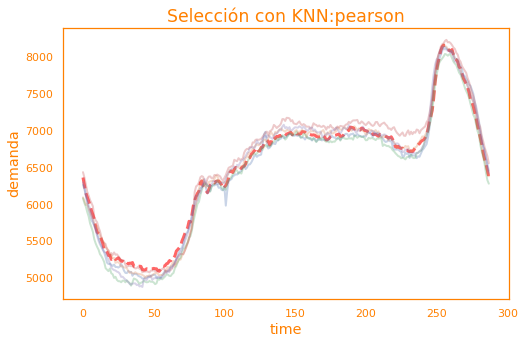

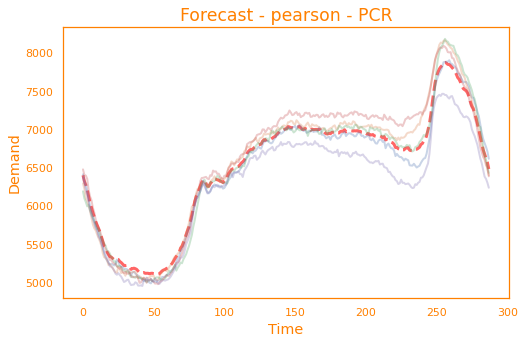

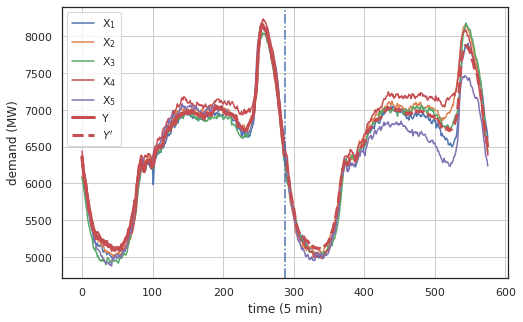

fail_ False
t_sel 3.618468761444092
t_reg 0.3992137908935547
prediction_Y2 [6397.94500156 6321.73331418 6269.00173258 6209.74449817 6120.31582741
 6040.56443922 5976.95354417 5908.40530563 5854.96411279 5793.63254479
 5748.33993881 5701.23251503 5657.69328392 5599.00642417 5536.24898358
 5472.31117862 5437.68735396 5397.78786948 5363.87603784 5335.319621
 5329.5933979  5312.60078702 5293.25592871 5294.19627419 5300.4740343
 5298.22432732 5272.37660961 5258.59524399 5239.0259223  5219.45781251
 5217.69155364 5220.28465209 5215.7272553  5197.69906001 5168.31759069
 5179.37572022 5184.41425105 5178.27390262 5168.19449498 5146.38161908
 5127.71888631 5121.12045554 5123.72280058 5127.58889429 5117.49561632
 5118.27711268 5118.17856618 5110.38936189 5117.19232784 5118.46546392
 5112.82991929 5109.57397512 5103.37770426 5106.22274943 5111.16341872
 5130.96537123 5149.49897817 5160.83625569 5167.26064528 5180.66397682
 5186.7971127  5200.74331487 5225.67927823 5246.08670603 5275.81786426
 5309

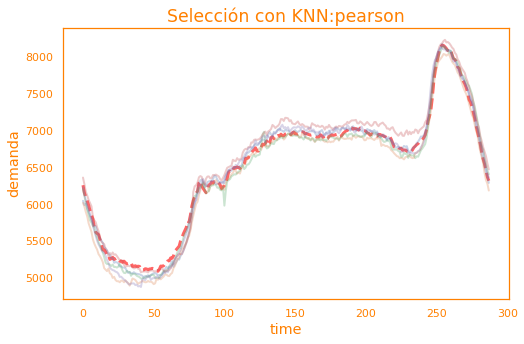

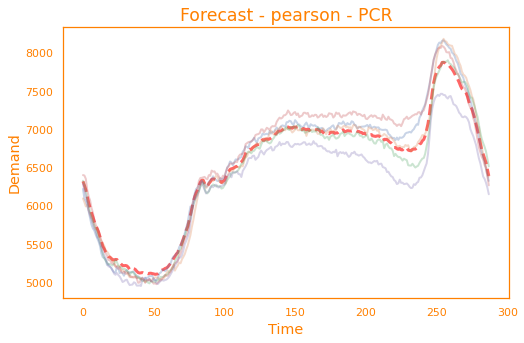

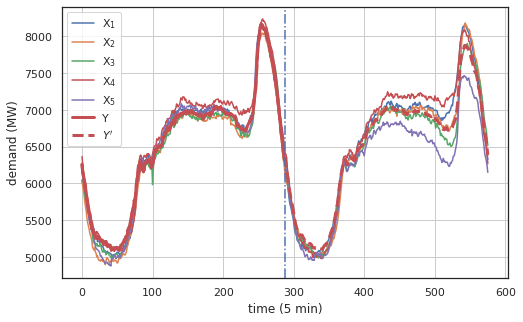

fail_ False
t_sel 3.606152057647705
t_reg 0.42551660537719727
prediction_Y2 [6319.40194209 6266.08461103 6207.1673607  6118.85658786 6039.20402799
 5975.61158931 5907.22284598 5853.83884914 5792.91649887 5747.57438689
 5700.83544284 5657.27443636 5598.65068988 5535.96549912 5472.44886026
 5438.16687828 5398.20786049 5364.11575906 5335.75096362 5329.52315183
 5312.46965071 5292.77258079 5293.266283   5298.63027544 5297.34273046
 5271.75378414 5257.62216573 5237.98850974 5218.56982532 5216.55169439
 5219.61686408 5215.29216377 5196.90755175 5167.91842501 5178.71621811
 5183.57204974 5177.78890484 5167.75166209 5145.6810546  5127.53011658
 5121.0223584  5123.30041329 5127.74315927 5117.53673859 5118.33050474
 5118.43082006 5110.7686988  5117.86155023 5118.66751174 5113.36606622
 5110.02796311 5103.86970286 5106.39880499 5111.40818563 5131.21183991
 5149.51869999 5160.96325812 5167.35230919 5180.54447588 5186.97693834
 5201.25936505 5225.81783542 5246.2947498  5276.35752873 5309.63620315
 

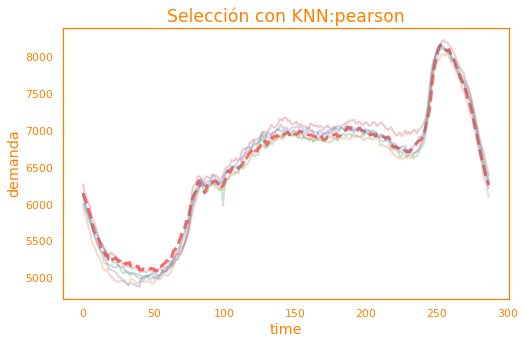

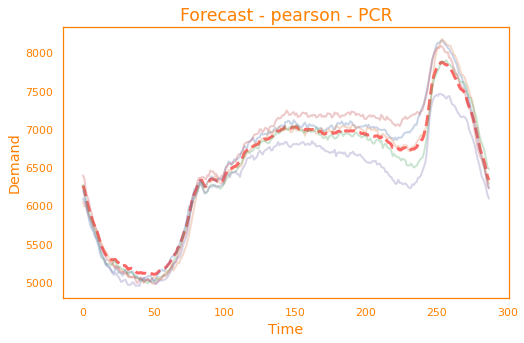

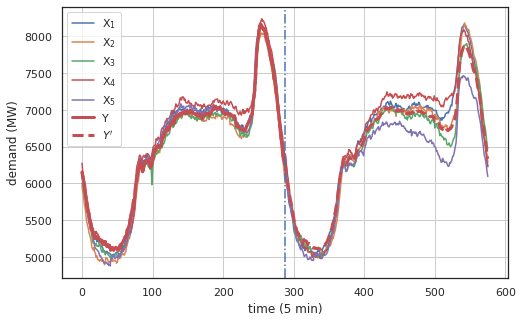

fail_ False
t_sel 3.6285593509674072
t_reg 0.3968346118927002
prediction_Y2 [6264.30078709 6205.58126854 6117.93133359 6038.32860634 5974.72356781
 5906.43115732 5853.0828575  5792.4226127  5747.05974873 5700.50852575
 5656.94611255 5598.36062247 5535.69870868 5472.43089259 5438.34933309
 5398.37319331 5364.14964672 5335.91651547 5329.39541458 5312.30994758
 5292.40066712 5292.6127302  5297.4652827  5296.78273983 5271.33698736
 5256.96209182 5237.32245808 5217.97863912 5215.80153917 5219.18301604
 5215.00524672 5196.38532158 5167.64840284 5178.29823411 5183.05213923
 5177.48937777 5167.4540131  5145.21739954 5127.39979468 5120.94099815
 5122.99685671 5127.80677272 5117.53602016 5118.38060363 5118.56829721
 5110.98115802 5118.24673681 5118.78674922 5113.68250213 5110.29325031
 5104.14103627 5106.47905551 5111.52985834 5131.36315766 5149.54039343
 5161.05378167 5167.41013762 5180.45755538 5187.06670352 5201.556856
 5225.90409663 5246.42534111 5276.68473119 5309.96343694 5338.45908972
 53

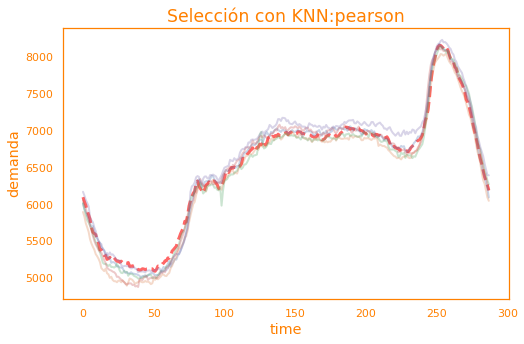

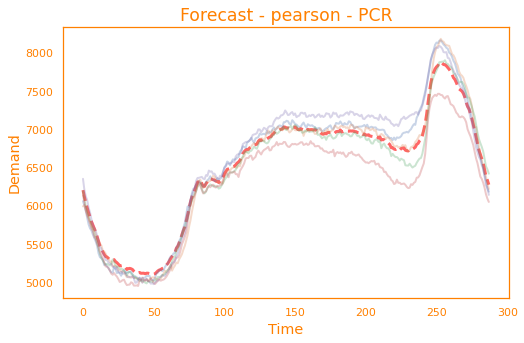

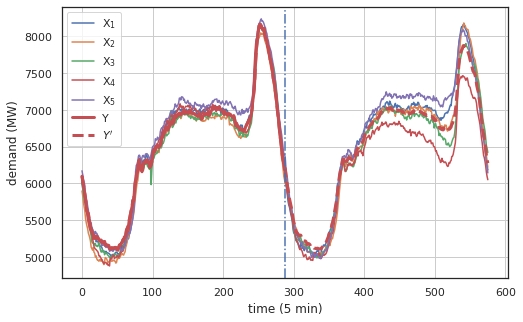

fail_ False
t_sel 3.629737377166748
t_reg 0.39192986488342285
prediction_Y2 [6204.22680269 6117.36433568 6037.74299474 5974.28653719 5906.29769588
 5852.95757636 5792.44223854 5747.10632515 5700.7892156  5657.26537816
 5598.72932213 5536.39614726 5473.42983015 5439.48097094 5399.3622862
 5365.10074813 5336.68630402 5329.89244257 5312.7270384  5292.56687911
 5292.38184786 5296.38448576 5296.12294743 5270.90070022 5256.52488121
 5236.55503843 5217.26396961 5215.09054092 5218.5590175  5214.49777834
 5195.6566764  5166.9856352  5177.44671667 5182.02435798 5176.84406728
 5167.0230977  5144.68502829 5127.10466915 5120.78797942 5122.77643447
 5128.23438309 5117.95976253 5118.7813646  5119.06976921 5111.49791838
 5118.98475672 5119.02717471 5114.16288776 5111.08951434 5104.93973403
 5106.86958264 5111.77814193 5131.38033058 5149.40038801 5160.87398221
 5167.17231774 5180.22034708 5187.02792863 5201.65587352 5225.65158846
 5246.28388926 5276.67596576 5309.9717018  5337.74191167 5366.92102107
 5

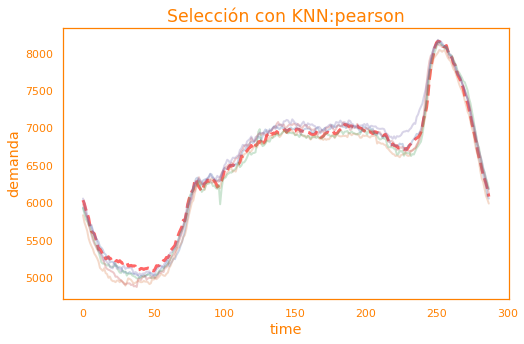

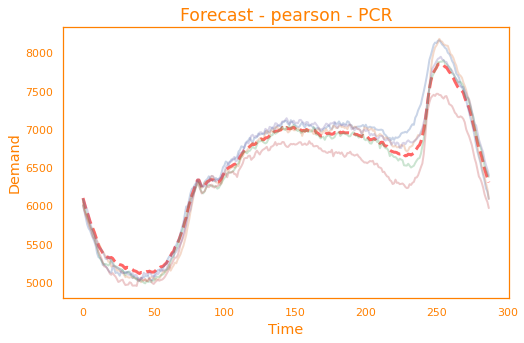

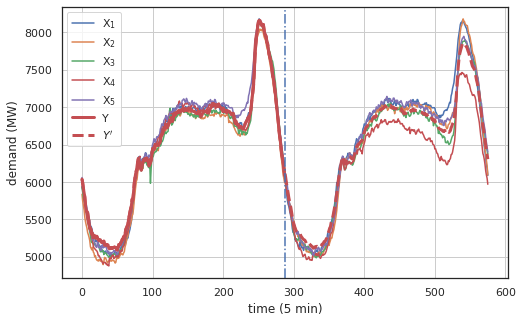

fail_ False
t_sel 3.640164613723755
t_reg 0.4295485019683838
prediction_Y2 [6100.93287744 6031.61386192 5967.43208628 5913.82676126 5855.91579208
 5794.32099302 5748.41074086 5699.2656907  5654.18697625 5598.43352446
 5542.75676496 5479.08179188 5446.83579238 5416.84402875 5383.20733655
 5357.99295661 5340.39299882 5330.07119021 5323.33070866 5318.75048863
 5324.25194964 5312.0405186  5284.53656071 5266.12108325 5254.77148544
 5239.83590595 5230.06389342 5226.94110673 5218.80120988 5199.5790183
 5178.34632871 5196.6086067  5192.50666745 5183.63970717 5177.41895931
 5166.41514069 5148.68812591 5147.19105623 5138.14159155 5122.55048951
 5114.5169687  5128.79480222 5127.33767265 5135.02651078 5132.76695695
 5141.03600553 5135.23171395 5145.7263009  5135.86996865 5132.80324647
 5134.01355663 5145.4474073  5167.69015658 5172.18418452 5180.84837068
 5202.73648329 5204.42683223 5216.63761986 5236.48344419 5252.58109688
 5284.74972858 5319.90206427 5348.81644394 5384.68258838 5401.25235984
 54

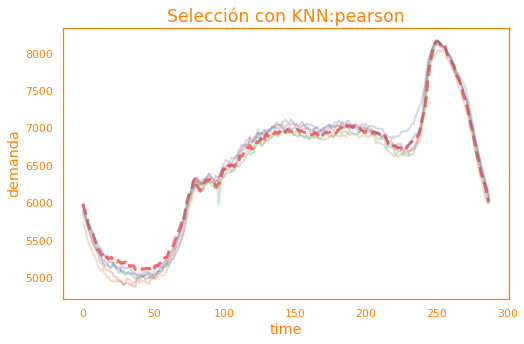

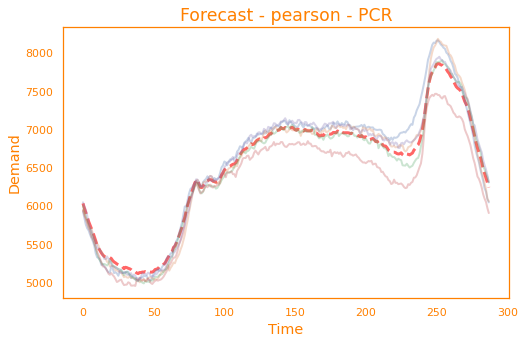

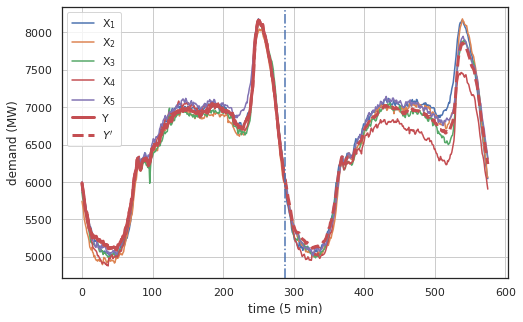

fail_ False
t_sel 3.6254384517669678
t_reg 0.5270364284515381
prediction_Y2 [6031.00282302 5966.86082289 5913.28499813 5855.31241444 5793.69170289
 5747.66210011 5698.6459522  5653.51450137 5597.76914995 5542.13089253
 5478.47609541 5446.37916521 5416.42094554 5382.78710698 5357.61393954
 5339.78394441 5329.48124853 5322.84198578 5318.1727052  5323.41774571
 5311.22551569 5283.77257189 5265.36346136 5253.9868898  5239.18189608
 5229.29714674 5226.10448352 5217.97094115 5198.81275111 5177.7133486
 5195.91813697 5191.68717858 5182.81360645 5176.6665538  5165.72796722
 5147.95964521 5146.54875109 5137.44810286 5121.65368004 5113.55078999
 5127.772056   5126.51847745 5134.42371864 5132.14075493 5140.36062636
 5134.58803893 5145.04910049 5135.23312385 5132.08076229 5133.36438945
 5144.71351724 5166.93219317 5171.43783485 5180.19334424 5202.16117226
 5203.81232765 5216.03980392 5235.79289169 5251.82307648 5284.16592654
 5319.30464346 5348.01654232 5383.88691963 5400.36382025 5454.47650102
 5

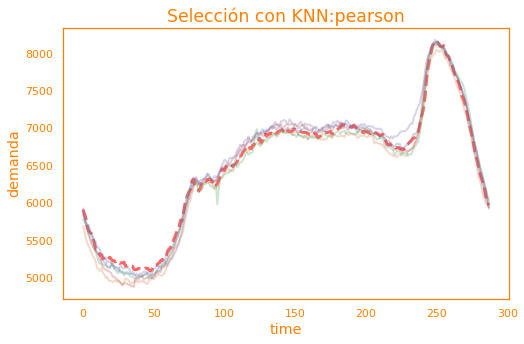

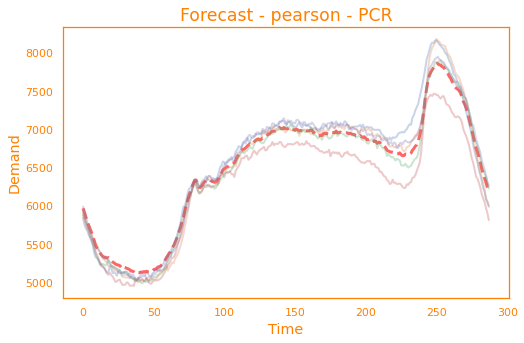

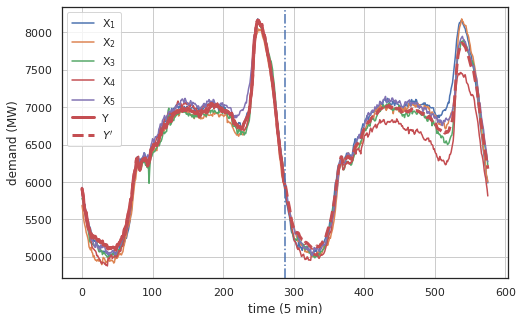

fail_ False
t_sel 3.6450796127319336
t_reg 0.41158246994018555
prediction_Y2 [5966.4895332  5912.96769393 5855.0239447  5793.47145661 5747.46092517
 5698.64015941 5653.44113022 5597.68556575 5542.14724679 5478.64174381
 5446.54992251 5416.43004265 5382.83833825 5357.60573605 5339.69539266
 5329.33690641 5322.47701789 5317.77509651 5322.67008705 5310.66796114
 5283.32409421 5264.92195073 5253.37390775 5238.59517518 5228.72775615
 5225.59597243 5217.49255751 5198.21903229 5177.0625054  5195.20738755
 5190.95111426 5182.18257002 5176.12813016 5165.10857945 5147.44479973
 5146.02867821 5136.95665056 5121.41099046 5113.31413187 5127.39146315
 5126.19696747 5133.99436749 5131.83526459 5139.85045806 5134.20943665
 5144.73644386 5134.97941269 5131.77359149 5132.99451581 5144.23491358
 5166.36847907 5170.85747168 5179.58426613 5201.52943985 5203.36386864
 5215.69082113 5235.27441231 5251.38670948 5283.7312015  5318.89245179
 5347.16788218 5383.02629996 5399.60759243 5453.60365226 5472.04523437


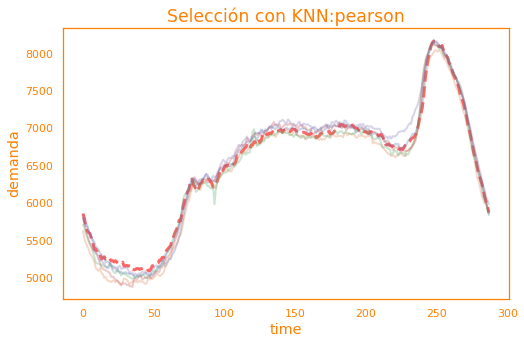

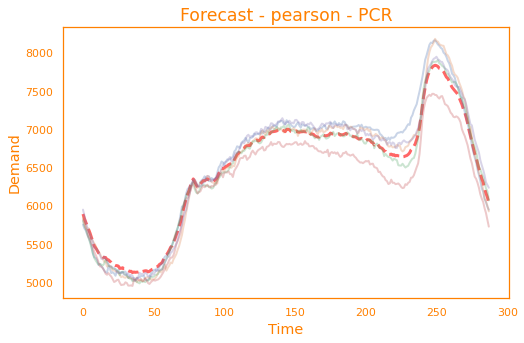

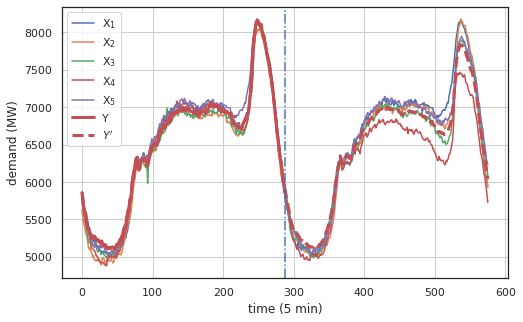

fail_ False
t_sel 3.5388565063476562
t_reg 0.41108226776123047
prediction_Y2 [5891.87896732 5832.48163485 5783.56889332 5731.88835207 5688.66939075
 5641.89754207 5584.33877718 5527.82415016 5474.58857955 5449.50271178
 5417.96319737 5383.41082268 5366.00247736 5342.80380063 5329.38954886
 5324.81597776 5323.86574562 5295.22317472 5293.51559542 5274.72300312
 5259.45471437 5237.12080931 5228.07058359 5218.51500057 5217.66352414
 5211.60993519 5181.92326832 5182.60919739 5190.29653878 5176.13958177
 5176.28015586 5171.68325182 5152.01149216 5142.08856607 5144.21590624
 5127.03004526 5134.51608529 5130.21732718 5132.78640485 5133.58815401
 5138.59976215 5153.17717015 5141.31323835 5145.64746634 5150.40754182
 5150.16150351 5135.91913477 5142.9145967  5158.61581693 5169.29398305
 5176.34941715 5187.47963287 5201.35298852 5208.65353908 5231.55956343
 5244.32502336 5260.19444985 5301.94914572 5342.17915468 5356.89744329
 5385.52390549 5419.13546638 5457.80135833 5476.15121191 5522.72829175


In [45]:
t_sel           = []
t_reg           = []
forecastAn_     = []
forecastAnMA_   = []
forecastX_An_   = []
forecastX_AnMA_ = []
n_p   = n_p  ## Number of periods per step
nfail = 0
fail_ = False
for to,tt,tf in positions_test:
    j=0
    s=n_p
    for i in range(tt,tf,1):
        ## Analogue method parameters
        vsele = vsele ## Number of periods in a window
        k     = k     ## Number of nearest neighbors
        tol   = 0.8   ## Closest tolerance percentage between neighbors
        d     = d
        m     = m
        X_train = numpy.array(serie1[to+j:tt+j])
        try:
            verbose=False
            if tt+j >= 43770:
                verbose =True
            pred_, t_sel_, t_reg_, fail_ = analogo_knn(X_train, vsele=vsele, k=k, tol=tol, typedist=d, typereg=m, verbose=verbose)
            t_sel.append(t_sel_)
            t_reg.append(t_reg_)
        except:
            print("!!! Error has occurred in the position:",to+j,tt+j)
        if fail_==True:              
            nfail = nfail + 1
            print(">>> Persistence forecast in position:",tt+j)
        pred_list  = pred_.tolist() 
        forecastAn_ = forecastAn_ + pred_list[0:1]
        print(j)
        if j >= vsele :
            a = -min(j,vsele) -1
            b = -1
            array1 = np.array(forecastAn_[a:b])
            c = tt + j - min(j,vsele)
            d = tt + j
            array2 = np.array(serie1[c:d])                         
            epsilon = np.subtract(array1,array2) ## Errores del primer pronóstico
            ar = AutoReg(epsilon, lags=3*n_p).fit()           
            delta = ar.forecast(1)
            MA_ = pred_list[0:1] - delta
            forecastAnMA_.extend(MA_)
            if s==n_p:
                forecastX_An_   = forecastX_An_ + pred_list[0:n_p]
                MA_ = pred_list[0:n_p] - delta
                forecastX_AnMA_.extend(MA_)
                s=0           
        else:
            if s==n_p:
                forecastX_An_   = forecastX_An_ + pred_list[0:n_p]
                forecastX_AnMA_ = forecastX_An_
                s=0            
            forecastAnMA_ = forecastAn_

        j=j+1
        s=s+1

    modu=(tf-tt)%n_p
    if modu != 0:
        end=min(len(forecastAn_),len(forecastX_An_))
        print('modu',modu)
        forecastAn_    = forecastAn_[    0:end]
        forecastAnMA_  = forecastAnMA_[  0:end]    
        forecastX_An_  = forecastX_An_[  0:end]
        forecastX_AnMA_= forecastX_AnMA_[0:end]    
print('>>>Number of forecasts not calculated:', nfail)

In [27]:
print(len(forecastAn_))

1


In [28]:
date_i = df_5.reset_index().iloc[tt].Date

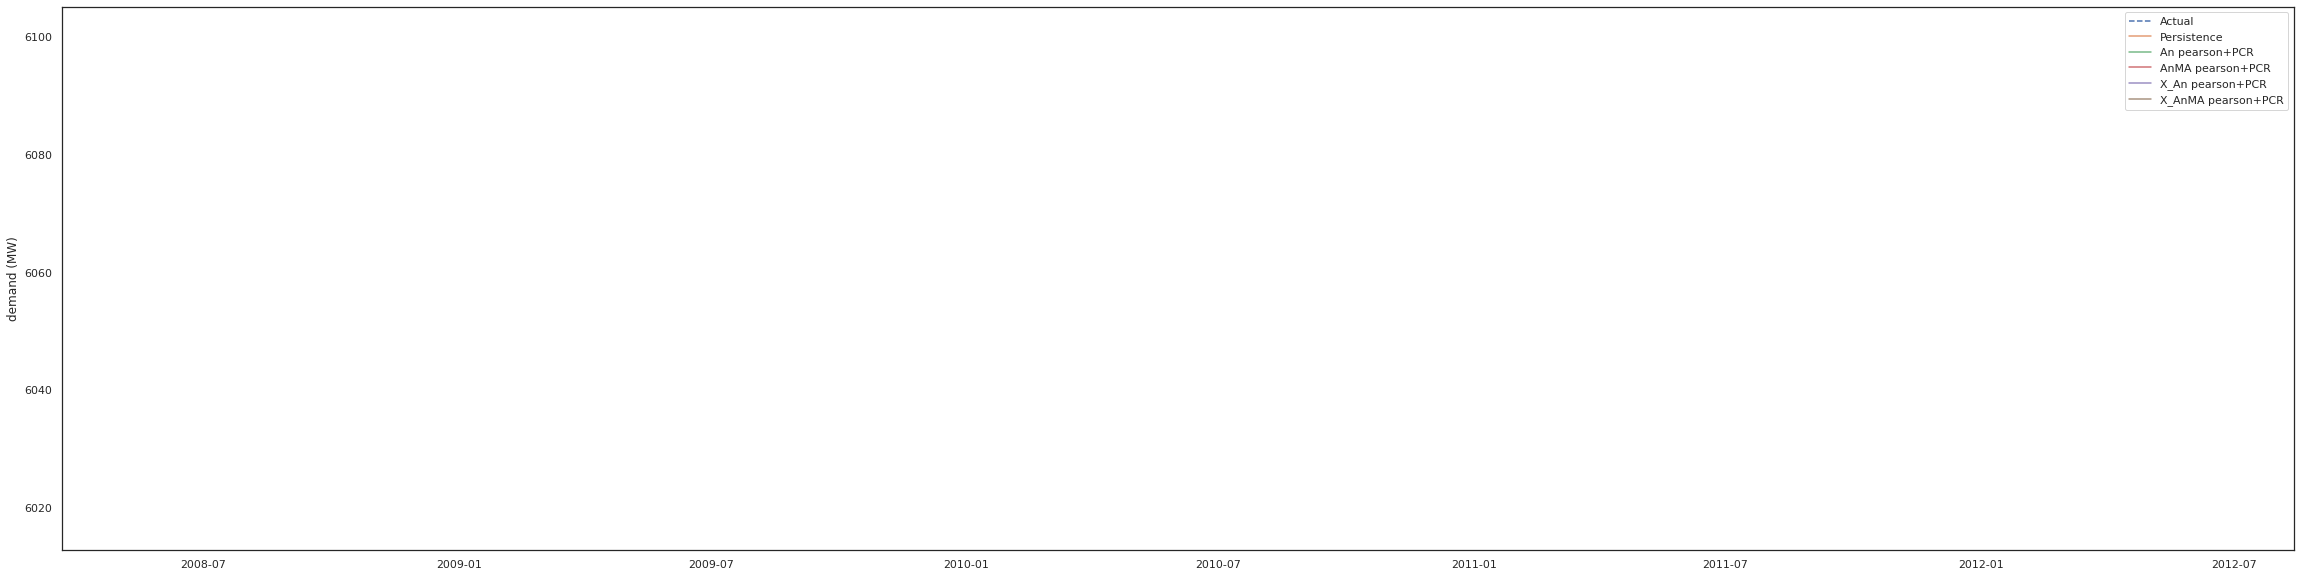

In [29]:
df_results = pd.DataFrame({
  'datetime'          : pd.date_range(date_i, periods=len(test_), freq="5T"),
  'Actual'            : test_,
  'Persistence'       : forecastp_,
  'An '    +d+'+'+m   : forecastAn_,
  'AnMA '  +d+'+'+m   : forecastAnMA_,
  'X_An '  +d+'+'+m   : forecastX_An_,
  'X_AnMA '+d+'+'+m   : forecastX_AnMA_,
})
df_results = df_results.set_index('datetime')

## Save in csv files
df_results.to_csv(namefile+'_'+serie+'_'+monthyear+'.csv')

plt.figure(figsize=(40, 10))
for c in df_results:
  if c == 'Actual':
    plt.plot(df_results[c], '--', label = c)
  else:
    plt.plot(df_results[c], label = c, alpha=0.8)
plt.legend()
plt.ylabel('demand (MW)')
plt.savefig('series_'+monthyear+'.pdf')
plt.show()

In [30]:
a=0; b=2000
mae_p  = mean_absolute_error(test_[a:b],forecastp_[a:b])
mape_p = mean_absolute_percentage_error(test_[a:b],forecastp_[a:b])
bias_p = bias.bias(test_[a:b],forecastp_[a:b])

In [31]:
mae_a  = mean_absolute_error(test_[a:b],forecastAn_)
mape_a = mean_absolute_percentage_error(test_[a:b],forecastAn_[a:b])
bias_a = bias.bias(test_[a:b],forecastAn_[a:b])

In [32]:
mae_ma  = mean_absolute_error(test_[a:b],forecastAnMA_[a:b])
mape_ma = mean_absolute_percentage_error(test_[a:b],forecastAnMA_[a:b])
bias_ma = bias.bias(test_[a:b],forecastAnMA_[a:b])

In [33]:
mae_xa  = mean_absolute_error(test_[a:b],forecastX_An_)
mape_xa = mean_absolute_percentage_error(test_[a:b],forecastX_An_[a:b])
bias_xa = bias.bias(test_[a:b],forecastX_An_[a:b])

In [34]:
mae_xma  = mean_absolute_error(test_[a:b],forecastX_AnMA_)
mape_xma = mean_absolute_percentage_error(test_[a:b],forecastX_AnMA_[a:b])
bias_xma = bias.bias(test_[a:b],forecastX_AnMA_[a:b])

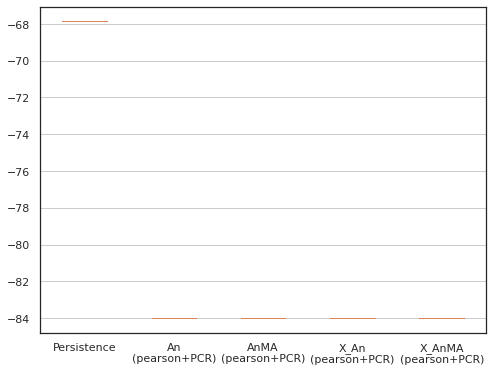

In [35]:
data = [diff(test_,forecastp_), diff(test_,forecastAn_), diff(test_,forecastAnMA_), diff(test_,forecastX_An_), diff(test_,forecastX_AnMA_)]
labels = ['Persistence', 'An\n('+d+'+'+m+')', 'AnMA\n('+d+'+'+m+')', 'X_An\n('+d+'+'+m+')', 'X_AnMA\n('+d+'+'+m+')',]
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; LETRASNARA ='#ff8000'; AZUL='#168fff'; OTROAZUL = "b-"; ROJO= "#FF0000"; # 'pink', 'lightblue', 'lightgreen',
#plt.tick_params(colors = LETRASNARA, which='both')
bplot1 = axes.boxplot(data,
                      vert=True,          # vertical box alignment
                      patch_artist=True,  # fill with color
                      labels=labels,)     # will be used to label x-ticks
#axes.set_title('Accuracy',fontsize='x-large',color = LETRASNARA)
#plt.tick_params(colors = LETRASNARA, which='both')
colors = ['pink', 'lightblue', 'lightgreen',LILA, AZUL] # fill with colors
for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)
axes.yaxis.grid(True) # adding horizontal grid lines
#axes.set_xlabel('Configuraciones de red',fontsize='large',color = LETRASNARA)
axes.set_ylabel('')
namefile = 'boxplot_'+monthyear+'.pdf'
plt.savefig(namefile, transparent=True)
plt.show()

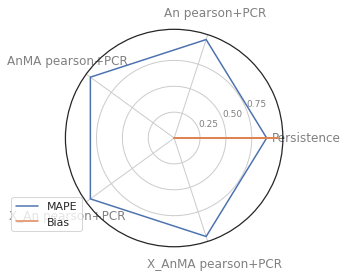

In [36]:
df_resultados = pd.DataFrame([
  {
    'method': 'Persistence',
    'mape'  : mape_p,
    'mae'   : mae_p, # Conviene normalizar esto (o quitarlo porque normalizado es como el mape)
    'bias'  : bias_p # Conviene normalizar esto
  },
  {
    'method': 'An '+d+'+'+m,
    'mape'  : mape_a,
    'mae'   : mae_a, 
    'bias'  : bias_a 
  },
  {
    'method': 'AnMA '+d+'+'+m,
    'mape'  : mape_ma,
    'mae'   : mae_ma,
    'bias'  : bias_ma 
  },
  {
    'method': 'X_An '+d+'+'+m,
    'mape'  : mape_xa,
    'mae'   : mae_xa,
    'bias'  : bias_xa 
  },  
  {
    'method': 'X_AnMA '+d+'+'+m,
    'mape'  : mape_xma,
    'mae'   : mae_xma,
    'bias'  : bias_xma
  },

  # etc.
])
categories = df_resultados.method
N = len(categories)

fig = plt.figure()
ax = fig.add_subplot(111, projection="polar")

theta = np.arange(len(df_resultados) + 1) / float(len(df_resultados)) * 2 * np.pi

values = df_resultados.mape.values
values = np.append(values, values[0])
values = values + abs(min(values))
values = values / max(values)
ax.plot(theta, values, label="MAPE")

values = df_resultados.bias.values
values = np.append(values, values[0])
values = values + abs(min(values))
values = values / max(values)
ax.plot(theta, values, label="Bias")

plt.xticks(theta[:-1], df_resultados.method, color='grey', size=12)
plt.yticks([0.25, 0.50, 0.75], ['0.25', '0.50', '0.75'], color='grey', size=9)
ax.tick_params(pad=10) # to increase the distance of the labels to the plot

plt.legend(loc='center right', bbox_to_anchor=(0.1, 0.15))

namefile = 'polar_'+monthyear+'.pdf'
plt.savefig(namefile, transparent=True)
plt.show()

time_jun2010 selection 15.411784172058105
time_jun2010 regresion 1.699385166168213


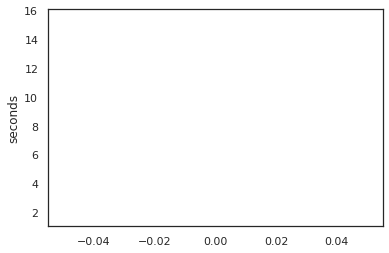

In [37]:
## mean time of selection and regression in seconds
plt.plot(t_sel,)
plt.plot(t_reg,)
plt.ylabel('seconds')
print('time_'+monthyear+' selection',(np.mean(t_sel)))
print('time_'+monthyear+' regresion',(np.mean(t_reg)))
namefile = 'time_'+monthyear+'.pdf'
plt.savefig(namefile, transparent=True)